In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Network(nn.Module):
    def __init__(self, output_size, activation = nn.Identity()):
        super(Network, self).__init__()
        # in this case, the number of channels is 10 because we retrieve last 10 snapshots
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv1d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.lstm = nn.LSTM(input_size=1, hidden_size=1, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(11, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.activation = activation
        

    def forward(self, x1, x2):
        x1 = self.conv1(x1) 
        x1 = F.relu(x1)
        x1 = self.conv2(x1)
        x1 = F.relu(x1)
        x1 = self.conv3(x1)
        x1 = F.relu(x1)
        x1 = x1.reshape(10, 1, 1)
        x1, _ = self.lstm(x1)
        x1 = x1.reshape(10, )
        x1 = torch.cat((x1, x2), dim = 0)
        x1 = self.fc1(x1)
        x1 = F.relu(x1)
        x1 = self.fc2(x1)
        x1 = F.relu(x1)
        x1 = self.fc3(x1)
        x1 = self.activation(x1)
        return x1
    

In [2]:
torch.__version__

'2.0.1+cu118'

In [3]:
df = pd.read_csv('cleaned_dataset.csv')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = df[df['trading_day'] == 25]
data = data.drop(['trading_day'], axis=1)
data = data[['AskPrice1', 'AskVolume1', 'BidPrice1', 'BidVolume1', 'AskPrice2', 'AskVolume2', 'BidPrice2', 'BidVolume2', 'AskPrice3', 'AskVolume3', 'BidPrice3', 'BidVolume3']]
train_data = data.iloc[:5000, :]
test_data = data.iloc[5000:10000, :]


In [4]:
train_data = train_data.to_numpy()
train_data = torch.from_numpy(train_data)
train_data = train_data.float()
train_data = train_data.to(device)


Therefore, I think it makes sense that to consider snapshots for the last 10 seconds as an input, and start from there. For each snapshot, we only use the first three bid-ask price level, which means 12 features

In [5]:
# write a function to get a path from the policy network
def get_path(policy_network, train_dataset):
    holding_positions = [0]
    pos_changes = []
    rewards = []
    states1 = []
    states2 = [] 
    action_dist_set = []
    action_set = []
    for i in range(9, len(train_dataset)):

        # bid_ask information of past 10 snapshots
        bid_ask = train_dataset[i - 9:i + 1, :]
        bid_ask = bid_ask.unsqueeze(0)
        old_hold = holding_positions[-1]
        hold = torch.tensor([old_hold]).float().to(device)
        states1.append(bid_ask)
        states2.append(hold)
        # get the action from the policy network, which is a probability distribution
        action_dist = policy_network(bid_ask, hold)
        action_dist_set.append(action_dist)
        # sample an action from the probability distribution
        action = torch.multinomial(action_dist, 1).item() - 1
        action_set.append(action + 1)
        
        # decide the position change based on the action and current holding position
        if old_hold == 0:
            # make the action to be integer
            a = int(action)
            holding_positions.append(a)
        if old_hold == 1:
            holding_positions.append(min(action + old_hold, old_hold))
        if old_hold == -1:
            holding_positions.append(max(action + old_hold, old_hold))
           
        # compute the reward (cash change) 
        new_hold = holding_positions[-1]
        position_change = new_hold - old_hold
        pos_changes.append(position_change)
    
        reward = 0
        if position_change == 0:
            reward = 0
        if position_change == 1:
            reward = - train_dataset[i][2] 
        if position_change == -1:
            reward = train_dataset[i][0] 

        rewards.append(reward)
    
    # at the end, the agent needs to liquid all positions
    if holding_positions[-1] == 1:
        rewards.append(train_dataset[-1][2])
    elif holding_positions[-1] == -1:
        rewards.append(-train_dataset[-1][0])
    else:
        rewards.append(0)

    # convert the list of rewards to a tensor
    rewards = torch.tensor(rewards).float().to(device)
    # convert the list of states to a tensor
    states1 = torch.stack(states1).to(device)
    states2 = torch.stack(states2).to(device)
    action_dist_set = torch.stack(action_dist_set).to(device)
    return states1, states2, rewards, action_dist_set, action_set


        
# train the value network using the TD(0) algorithm
def train_value_network(value_network, policy_network, train_dataset, value_optimizer, gamma = 0.99, epochs = 20):
    # define the loss function
    loss = 0
    losses = []
    # loop over the epochs
    for epoch in range(epochs):
        # get the path from the policy network
        # only use one trajectory each epoch
        states1, states2, rewards, action_dist_set, action_set = get_path(policy_network, train_dataset)
        # get the value estimate from the value network
        value_estimate = []
        for i in range(len(states1)):
            value_estimate.append(value_network(states1[i], states2[i]))
        value_estimate = torch.stack(value_estimate).squeeze(1)
        new_value_estimate = torch.cat((value_estimate, torch.tensor([0]).to(device)))
        # compute the TD(0) error
        loss = (rewards[:-1] + gamma * new_value_estimate[1:] - new_value_estimate[:-1]).pow(2).mean()
        # zero the gradient
        value_optimizer.zero_grad()
        # compute the gradient
        loss.backward()
        # update the weights
        value_optimizer.step()
        # print the loss
        losses.append(loss.item())
        if (epoch - 4) % 5 == 0:
            print('value epoch: {}, value loss: {:.5f}'.format(epoch + 1, loss.item()))

    #plt.figure(figsize = (10, 5))
    #plt.plot(losses)
    #plt.xlabel('Epoch')
    #plt.ylabel('Loss')
    #plt.title('Loss over Epochs')
    #plt.show()
    return losses


# the following define a function that compute advantage estimation for a trajectory
def advantage_estimate(states1, states2, rewards, value_network, gamma):
    value_estimate = []
    for i in range(len(states1)):
        value_estimate.append(value_network(states1[i], states2[i]))
    value_estimate = torch.stack(value_estimate).squeeze(1)
    new_value_estimate = torch.cat((value_estimate, torch.tensor([0]).to(device)))
    advantages = rewards[:-1] + gamma * new_value_estimate[1:] - new_value_estimate[:-1]
    return advantages


        

In [6]:
# states, rewards, actions are trajetory data of old policy
# there is a new_policy_network that is updated by ppo_update()
def ppo_loss(new_policy_network, policy_network, value_network, train_dataset, batch_size, epsilon=0.2, gamma = 0.99):
    # batch size: the number of trajectories
    loss = torch.tensor(0.0, requires_grad=True).to(device)
    for _ in range(batch_size):
        states1, states2, rewards, action_dist_set, action_set = get_path(policy_network, train_dataset)
        new_action_dist_set = [new_policy_network(states1[i], states2[i]) for i in range(len(states1))]
        new_action_dist_set = torch.stack(new_action_dist_set).to(device)
        action_dist_set = action_dist_set.detach()
        rewards = rewards.detach()
        ratio = []
        for i in range(len(action_dist_set)):
            ratio.append(new_action_dist_set[i][action_set[i]] / action_dist_set[i][action_set[i]])
        ratio = torch.stack(ratio).to(device).detach()
        # compute the advantage of the trajectory
        advantage = advantage_estimate(states1, states2, rewards, value_network, gamma)
        advantage = advantage.detach()
        # compute the clipped ratio
        clipped_ratio = torch.clamp(ratio, 1.0 - epsilon, 1.0 + epsilon)
        # compute the surrogate loss
        policy_loss = -torch.min(ratio * advantage, clipped_ratio * advantage).mean()
        # compute the total loss
        loss = loss + policy_loss
    return loss

    
def ppo_train(new_policy_network, policy_network, value_network, optimizer, train_dataset, batch_size, epochs, epsilon=0.1, gamma = 0.99):
    
    for epoch in range(epochs):
        loss = ppo_loss(new_policy_network, policy_network, value_network, train_dataset, batch_size, epsilon, gamma)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return None
    


def wealth_dist(num_traj, policy_network, dataset):
    wealths = []
    for num in range(num_traj):
        states1, states2, rewards, action_dist_set, action_set = get_path(policy_network, dataset)
        wealths.append(sum(rewards))

    return wealths


In [9]:
policy_network = Network(3, activation = nn.Softmax())
value_network = Network(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_network = nn.DataParallel(policy_network)
value_network = nn.DataParallel(value_network)
policy_network.to(device)
value_network.to(device)

oldest_policy_network = Network(3, activation = nn.Softmax()).to(device)
oldest_policy_network.load_state_dict(policy_network.state_dict(), strict=False)

policy_network = torch.compile(policy_network)
value_network = torch.compile(value_network)

policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.01)
value_optimizer = optim.Adam(value_network.parameters(), lr=0.03)


In [10]:
num_iter = 20
# num_iter this is the number of times that we improve the policy
# batch_size is the number of trajectories used of computing ppo loss
# epoch is the number of trains for ppo updates
torch._dynamo.config.suppress_errors = True
wealth_records = []
value_losses = []
ppo = []

for iteration in range(num_iter):
    print("iteration: ", iteration)
    value_loss = train_value_network(value_network, policy_network, train_data, value_optimizer, 0.9, epochs = 1)

    value_losses += value_loss

    new_policy_network = Network(3, activation = nn.Softmax()).to(device)
    new_policy_network.load_state_dict(policy_network.state_dict(), strict=False)
    new_policy_network = nn.DataParallel(new_policy_network)
    new_policy_optimizer = optim.Adam(new_policy_network.parameters(), lr = 0.03)
    new_policy_network = torch.compile(new_policy_network)
        
    ppo_train(new_policy_network, policy_network, value_network, new_policy_optimizer, train_data, batch_size = 1, epochs = 1, epsilon = 0.1, gamma = 0.99)
    policy_network = new_policy_network

    print('this is value loss')
    print(value_losses[-1])

    loss = ppo_loss(policy_network, oldest_policy_network, value_network, train_data, 1, epsilon=0.2, gamma = 0.99)
    ppo.append(loss.item())
    print('this is ppo loss')
    print(ppo[-1])

    #print('this is ppo loss')
    #print(ppo_losses[-1])
    #w = wealth_dist(3, policy_network, train_data)
    #wealth_record = []
    #for r in w:
        #wealth_record.append(r.item())
    #wealth_records.append(wealth_record)


iteration:  0


/tmp/ipykernel_31742/2842180769.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x1 = self.activation(x1)


this is value loss
264517.90625
this is ppo loss
-1.471575379371643
iteration:  1
this is value loss
253156.765625
this is ppo loss
8.560065269470215
iteration:  2
this is value loss
275063.28125
this is ppo loss
-7.890795707702637
iteration:  3
this is value loss
241833.875
this is ppo loss
13.787890434265137
iteration:  4
this is value loss
271220.34375
this is ppo loss
0.5593961477279663
iteration:  5
this is value loss
271131.90625
this is ppo loss
47.227603912353516
iteration:  6
this is value loss
248062.328125
this is ppo loss
6.109338283538818
iteration:  7
this is value loss
242640.5625
this is ppo loss
18.4940128326416
iteration:  8
this is value loss
242513.734375
this is ppo loss
-9.121710777282715
iteration:  9
this is value loss
226931.171875
this is ppo loss
-0.06955420225858688
iteration:  10
this is value loss
223503.625
this is ppo loss
10.242080688476562
iteration:  11
this is value loss
217781.1875
this is ppo loss
25.953126907348633
iteration:  12
this is value los

In [12]:

for iteration in range(num_iter):
    print("iteration: ", iteration)
    value_loss = train_value_network(value_network, policy_network, train_data, value_optimizer, 0.9, epochs = 1)

    value_losses += value_loss

    new_policy_network = Network(3, activation = nn.Softmax()).to(device)
    new_policy_network.load_state_dict(policy_network.state_dict(), strict=False)
    new_policy_network = nn.DataParallel(new_policy_network)
    new_policy_optimizer = optim.Adam(new_policy_network.parameters(), lr = 0.03)
    new_policy_network = torch.compile(new_policy_network)
        
    ppo_train(new_policy_network, policy_network, value_network, new_policy_optimizer, train_data, batch_size = 1, epochs = 1, epsilon = 0.1, gamma = 0.99)
    policy_network = new_policy_network

    print('this is value loss')
    print(value_losses[-1])

    loss = ppo_loss(policy_network, oldest_policy_network, value_network, train_data, 1, epsilon=0.2, gamma = 0.99)
    ppo.append(loss.item())
    print('this is ppo loss')
    print(ppo[-1])

    #print('this is ppo loss')
    #print(ppo_losses[-1])
    #w = wealth_dist(3, policy_network, train_data)
    #wealth_record = []
    #for r in w:
        #wealth_record.append(r.item())
    #wealth_records.append(wealth_record)

iteration:  0


/tmp/ipykernel_31742/2842180769.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x1 = self.activation(x1)


this is value loss
30808.732421875
this is ppo loss
0.2400098443031311
iteration:  1
this is value loss
13815.720703125
this is ppo loss
-1.6978731155395508
iteration:  2
this is value loss
4988.0224609375
this is ppo loss
-3.596036911010742
iteration:  3
this is value loss
4783.9287109375
this is ppo loss
0.4210464060306549
iteration:  4
this is value loss
12416.720703125
this is ppo loss
-8.780088424682617
iteration:  5
this is value loss
14528.365234375
this is ppo loss
-6.275618553161621
iteration:  6
this is value loss
22032.41015625
this is ppo loss
-8.067083358764648
iteration:  7
this is value loss
25723.62109375
this is ppo loss
-8.917606353759766
iteration:  8
this is value loss
11325.712890625
this is ppo loss
-0.33248665928840637
iteration:  9
this is value loss
9317.9326171875
this is ppo loss
-5.332903861999512
iteration:  10
this is value loss
6920.638671875
this is ppo loss
1.7526935338974
iteration:  11
this is value loss
5247.29052734375
this is ppo loss
-0.0799549072

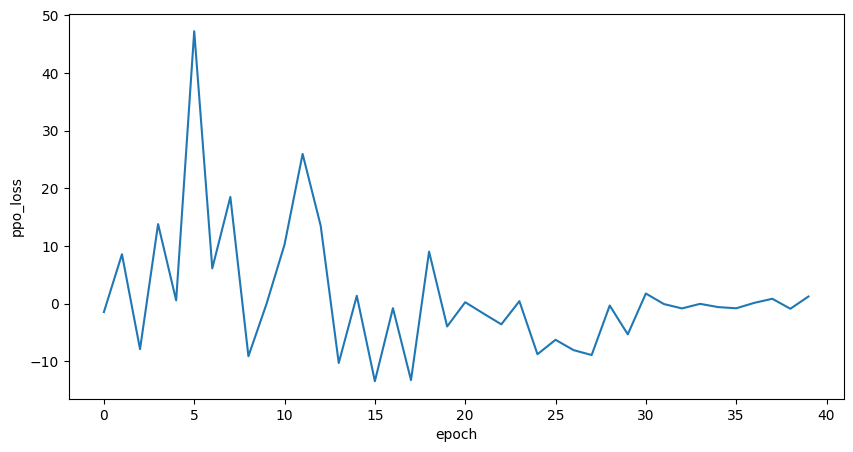

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(ppo)), ppo)
plt.ylabel('ppo_loss')
plt.xlabel('epoch')
plt.show()

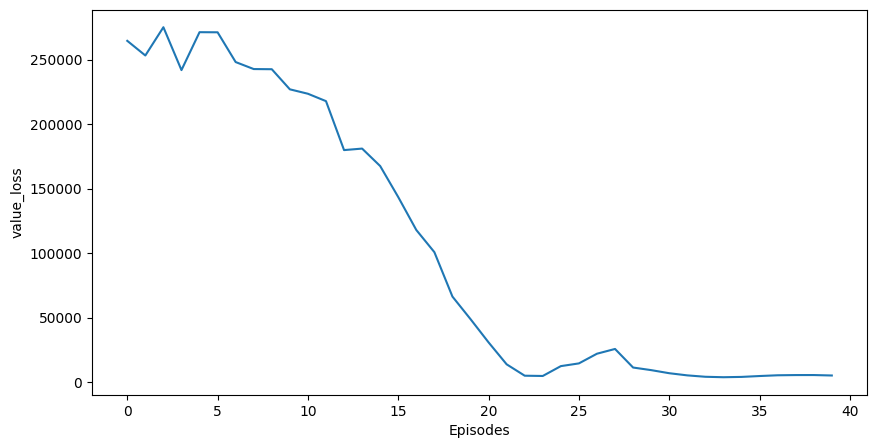

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(value_losses)), value_losses)
plt.ylabel('value_loss')
plt.xlabel('Episodes')
plt.show()

In [ ]:
wealth_records
torch.save(policy_network.state_dict(), 'policy_parameters.pth')
torch.save(value_network.state_dict(), 'value_parameters.pth')
wealth_numpy = np.array(wealth_records)
np.save('wealth_samples.npy', wealth_numpy)

In [ ]:
print(wealth_numpy)

[[422.  447.  420.  439.  432.5 442.  440.  443.  425.5 439. ]
 [443.5 453.5 458.5 458.5 442.  461.5 453.5 460.  465.  467.5]
 [422.  410.5 401.  433.5 423.5 424.5 427.  425.  424.5 424.5]
 [432.  430.5 441.  460.5 432.  443.5 445.  443.5 461.5 439. ]
 [423.  423.5 433.  441.  445.5 441.5 449.  439.5 428.5 423.5]]
